In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/proryv-hack/DF_ITOG_V1.csv
/kaggle/input/proryv-hack/DF_ITOG_V2.csv


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer, BertModel
from tqdm import tqdm

In [3]:
TRAINTRUE = pd.read_csv('/kaggle/input/proryv-hack/DF_ITOG_V1.csv')
TRAINRAND = pd.read_csv('/kaggle/input/proryv-hack/DF_ITOG_V2.csv')

In [4]:
TRAINTRUE['review_type'] = TRAINTRUE['review_type'].apply(lambda x: int(x) if x in ['0', '1', '2'] else 0).astype(int)

In [5]:
TRAINRAND['relevance'].value_counts()

relevance
1    909
0     64
Name: count, dtype: int64

In [6]:
TRAINTRUE['review_type'].iloc[0]

2

In [7]:
class UniversalDataset(Dataset):
    def __init__(self, bert_no_q, bert_yes_q, avg_score, relevance, review_type):
        self.bert_no_q = bert_no_q.to_numpy()
        self.bert_yes_q = bert_yes_q.to_numpy()
        self.avg_score = torch.tensor(avg_score.astype(float).to_numpy(), dtype=torch.float32)
        self.relevance = torch.tensor(relevance.astype(float).to_numpy(), dtype=torch.float32)
        self.review_type = torch.tensor(review_type.astype(float).to_numpy(), dtype=torch.float32)
        
    def __getitem__(self, idx):
        out = {}
        out['bert_no_q'] = self.bert_no_q[idx]
        out['bert_yes_q'] = self.bert_yes_q[idx]
        out['avg_score'] = self.avg_score[idx]
        out['relevance'] = self.relevance[idx]
        out['review_type'] = self.review_type[idx]
        return out
        
    def __len__(self):
        return len(self.avg_score)

TASK1 - REGRESSION (SCORE) BERT_NO_Q ROMA

In [68]:
from sklearn.model_selection import train_test_split

X = TRAINTRUE.drop(columns='avg_score')
Y = TRAINTRUE['avg_score']

XTRAIN, XVAL, YTRAIN, YVAL = train_test_split(X, Y, test_size=0.01, stratify=Y, random_state=666, shuffle=True)

In [69]:
TRAINSET = UniversalDataset(XTRAIN['bert_no_q'], XTRAIN['bert_yes_q'], YTRAIN, XTRAIN['relevance'], XTRAIN['review_type'])
VALSET = UniversalDataset(XVAL['bert_no_q'], XVAL['bert_yes_q'], YVAL, XVAL['relevance'], XVAL['review_type'])

In [70]:
len(TRAINSET)

912

In [71]:
BATCH_SIZE = 8

TRAINLOADER = DataLoader(TRAINSET, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
VALLOADER = DataLoader(VALSET, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [72]:
DEVICE = 'cuda'

class SentimentNNRegressor(nn.Module):
    def __init__(self):
        super(SentimentNNRegressor, self).__init__()
        self.bert1 = BertModel.from_pretrained('cointegrated/LaBSE-en-ru').to(DEVICE)
        self.bert2 = BertModel.from_pretrained('DeepPavlov/rubert-base-cased').to(DEVICE)
        self.tokenizer1 = AutoTokenizer.from_pretrained('cointegrated/LaBSE-en-ru')
        self.tokenizer2 = AutoTokenizer.from_pretrained('DeepPavlov/rubert-base-cased')
        
        self.fc1 = nn.Sequential(
            nn.Linear(768, 512),
            nn.BatchNorm1d(num_features=512),
            nn.GELU(),
            nn.Dropout(0.1)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(768, 512),
            nn.BatchNorm1d(num_features=512),
            nn.GELU(),
            nn.Dropout(0.1)
        )
        self.head = nn.Linear(1024, 1)
    
    def freeze_berts(self):
        for bert in [self.bert1, self.bert2]:
            for param in bert.parameters():
                param.requires_grad = False
        
    def mean_pooling(self, model_output, attention_mask):
        token_embeddings = model_output[0].to(DEVICE)
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
        sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        return sum_embeddings / sum_mask
    
    def forward(self, bert_no_q):
        x = self.tokenizer1(bert_no_q, padding=True, truncation=True, max_length=256, return_tensors="pt")\
            .to(DEVICE)
        y = self.tokenizer2(bert_no_q, padding=True, truncation=True, max_length=256, return_tensors="pt")\
            .to(DEVICE)
        x_out = self.bert1(**x)
        y_out = self.bert2(**y)
        x_emb = self.mean_pooling(x_out, x["attention_mask"]).to(DEVICE)
        y_emb = self.mean_pooling(y_out, y["attention_mask"]).to(DEVICE)
        
        x_emb = self.fc1(x_emb).to(DEVICE)
        y_emb = self.fc2(y_emb).to(DEVICE)
        xy_emb = torch.cat((x_emb, y_emb), dim=1).to(DEVICE)
        out = self.head(xy_emb).to(DEVICE)
        return out
    
nn1 = SentimentNNRegressor()
nn1.train()
nn1.freeze_berts()
nn1.to('cuda')
print("done...")

done...


In [73]:
TRAINSET[0]['bert_no_q']

'Итоговая контрольная работа по основному блоку. 1. Контрольная работа - важная часть завершения обучения. Вспомнила то, что где-то подзабыла. 2. Не поняла сразу, что нужно делать, так как сама задача была ниже пунктов, которые нужно было выполнить. 3. Нужно поднять задачу выше. Скорость проверки работы порадовала. 4. Подробнее изучить формулировку задач в контрольной работе.'

In [74]:
nn1.eval()
torch.flatten(nn1(TRAINSET[0]['bert_no_q']))

tensor([-0.0272], device='cuda:0', grad_fn=<ViewBackward0>)

In [94]:
!zip -r NN1_RATING_REGR_NOHEADINGS.zip *

  adding: NN1_RATING_REGR_NOHEADINGS.pth (deflated 7%)


In [75]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import ExponentialLR
from tqdm import tqdm
from transformers import logging
import os
from sklearn.metrics import classification_report, f1_score, roc_auc_score

os.environ["TOKENIZERS_PARALLELISM"] = "false"
logging.set_verbosity_error()

LR = 3e-4
EPOCHS = 3

nn1.train()
nn1.freeze_berts()

# loss_func = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([]))
loss_func = nn.MSELoss()
optimizer = AdamW(lr=LR, params=nn1.parameters())
scheduler = ExponentialLR(gamma=0.8, optimizer=optimizer)
LOSSES_TRAIN, LOSSES_VAL = [], []

for epoch in tqdm(range(EPOCHS)):
    cc_loss = 0
    nn1.train()
    nn1.freeze_berts()
    for step, batch in tqdm(enumerate(TRAINLOADER)):
        inp = batch['bert_no_q']
        labels = batch['avg_score'].to(DEVICE)
        
        optimizer.zero_grad()
        
        preds = torch.flatten(nn1(inp)).to(DEVICE)
        loss = loss_func(preds, labels)
        
        loss.backward()
        optimizer.step()
        
        cc_loss += loss.item()
        
        if step % 4 == 0:
            LOSSES_TRAIN.append(cc_loss/4)
            print(f"LOSS ON TRAIN STEP {step}: {cc_loss/4.:3f}")
            cc_loss = 0
        
    scheduler.step()
    nn1.eval()
    nn1.freeze_berts()
    cc_loss = 0
    for step, batch in tqdm(enumerate(VALLOADER)):
        inp = batch['bert_no_q']
        labels = batch['avg_score'].to(DEVICE)

        preds = torch.flatten(nn1(inp)).to(DEVICE)
        loss = loss_func(preds, labels)

        cc_loss += loss.item()

        if step % 4 == 0:
            LOSSES_VAL.append(cc_loss/4)
            print(f"LOSS ON EVAL STEP {step}: {cc_loss/4.:3f}")
            cc_loss = 0

  0%|          | 0/3 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:00,  7.41it/s]
2it [00:00,  8.39it/s]

LOSS ON TRAIN STEP 0: 4.163280



3it [00:00,  8.52it/s]
4it [00:00,  9.03it/s]
6it [00:00, 11.43it/s]

LOSS ON TRAIN STEP 4: 13.828569



8it [00:00, 10.62it/s]
10it [00:00, 10.64it/s]

LOSS ON TRAIN STEP 8: 10.210661



12it [00:01, 10.83it/s]
14it [00:01, 10.72it/s]

LOSS ON TRAIN STEP 12: 7.792003



16it [00:01, 10.27it/s]
18it [00:01, 11.16it/s]

LOSS ON TRAIN STEP 16: 7.450032



20it [00:01, 10.30it/s]
22it [00:02, 10.84it/s]

LOSS ON TRAIN STEP 20: 5.784853



24it [00:02, 11.08it/s]
26it [00:02, 11.05it/s]

LOSS ON TRAIN STEP 24: 5.158296



28it [00:02, 11.69it/s]
30it [00:02, 12.15it/s]

LOSS ON TRAIN STEP 28: 4.209193



32it [00:02, 11.12it/s]
34it [00:03, 10.40it/s]

LOSS ON TRAIN STEP 32: 2.792009



36it [00:03, 10.54it/s]
38it [00:03, 10.74it/s]

LOSS ON TRAIN STEP 36: 2.052988



40it [00:03, 10.91it/s]
42it [00:03, 11.84it/s]

LOSS ON TRAIN STEP 40: 2.205053



44it [00:04, 11.44it/s]
46it [00:04, 11.25it/s]

LOSS ON TRAIN STEP 44: 1.405382



48it [00:04, 11.24it/s]
50it [00:04, 11.59it/s]

LOSS ON TRAIN STEP 48: 1.355510



52it [00:04, 11.19it/s]
54it [00:04, 11.28it/s]

LOSS ON TRAIN STEP 52: 1.048326



56it [00:05, 11.25it/s]
58it [00:05, 11.26it/s]

LOSS ON TRAIN STEP 56: 1.336194



60it [00:05, 11.01it/s]
62it [00:05, 11.27it/s]

LOSS ON TRAIN STEP 60: 1.438872



64it [00:05, 11.08it/s]
66it [00:05, 11.81it/s]

LOSS ON TRAIN STEP 64: 1.101209



68it [00:06, 10.56it/s]
70it [00:06, 10.68it/s]

LOSS ON TRAIN STEP 68: 1.256213



72it [00:06, 11.41it/s]
74it [00:06, 11.01it/s]

LOSS ON TRAIN STEP 72: 1.162696



76it [00:06, 10.83it/s]
78it [00:07, 10.78it/s]

LOSS ON TRAIN STEP 76: 1.050626



80it [00:07, 10.90it/s]
82it [00:07, 11.54it/s]

LOSS ON TRAIN STEP 80: 1.521456



84it [00:07, 11.48it/s]
86it [00:07, 11.26it/s]

LOSS ON TRAIN STEP 84: 1.425784



88it [00:08, 10.99it/s]
90it [00:08, 10.69it/s]

LOSS ON TRAIN STEP 88: 0.793161



92it [00:08, 11.01it/s]
94it [00:08, 10.93it/s]

LOSS ON TRAIN STEP 92: 1.705758



96it [00:08, 11.05it/s]
98it [00:08, 11.84it/s]

LOSS ON TRAIN STEP 96: 0.979275



100it [00:09, 10.33it/s]
102it [00:09, 11.13it/s]

LOSS ON TRAIN STEP 100: 2.198745



104it [00:09, 11.53it/s]
106it [00:09, 11.77it/s]

LOSS ON TRAIN STEP 104: 1.761882



108it [00:09, 11.53it/s]
110it [00:09, 11.74it/s]

LOSS ON TRAIN STEP 108: 0.916475



112it [00:10, 11.45it/s]
114it [00:10, 10.96it/s]

LOSS ON TRAIN STEP 112: 1.240271




0it [00:00, ?it/s]
2it [00:00,  7.99it/s]
 33%|███▎      | 1/3 [00:11<00:22, 11.00s/it]

LOSS ON EVAL STEP 0: 0.745387



0it [00:00, ?it/s]
1it [00:00,  7.85it/s]
2it [00:00,  8.88it/s]

LOSS ON TRAIN STEP 0: 0.146927



3it [00:00,  9.12it/s]
4it [00:00,  9.40it/s]
6it [00:00, 11.73it/s]

LOSS ON TRAIN STEP 4: 0.659512



8it [00:00, 10.86it/s]
10it [00:00, 10.71it/s]

LOSS ON TRAIN STEP 8: 0.952889



12it [00:01, 10.94it/s]
14it [00:01, 10.71it/s]

LOSS ON TRAIN STEP 12: 0.760806



16it [00:01, 10.33it/s]
18it [00:01, 11.15it/s]

LOSS ON TRAIN STEP 16: 0.612032



20it [00:01, 10.33it/s]
22it [00:02, 10.80it/s]

LOSS ON TRAIN STEP 20: 0.631093



24it [00:02, 11.10it/s]
26it [00:02, 11.01it/s]

LOSS ON TRAIN STEP 24: 0.780116



28it [00:02, 11.70it/s]
30it [00:02, 12.04it/s]

LOSS ON TRAIN STEP 28: 0.536554



32it [00:02, 11.10it/s]
34it [00:03, 10.33it/s]

LOSS ON TRAIN STEP 32: 0.724368



36it [00:03, 10.49it/s]
38it [00:03, 10.67it/s]

LOSS ON TRAIN STEP 36: 0.702089



40it [00:03, 10.92it/s]
42it [00:03, 11.79it/s]

LOSS ON TRAIN STEP 40: 0.531060



44it [00:04, 11.37it/s]
46it [00:04, 11.17it/s]

LOSS ON TRAIN STEP 44: 0.678577



48it [00:04, 11.21it/s]
50it [00:04, 11.54it/s]

LOSS ON TRAIN STEP 48: 0.381037



52it [00:04, 11.10it/s]
54it [00:04, 11.16it/s]

LOSS ON TRAIN STEP 52: 0.383246



56it [00:05, 11.12it/s]
58it [00:05, 11.07it/s]

LOSS ON TRAIN STEP 56: 0.560640



60it [00:05, 10.90it/s]
62it [00:05, 11.15it/s]

LOSS ON TRAIN STEP 60: 0.610448



64it [00:05, 11.00it/s]
66it [00:05, 11.93it/s]

LOSS ON TRAIN STEP 64: 0.397818



68it [00:06, 10.66it/s]
70it [00:06, 10.78it/s]

LOSS ON TRAIN STEP 68: 0.663249



72it [00:06, 11.48it/s]
74it [00:06, 11.06it/s]

LOSS ON TRAIN STEP 72: 0.468918



76it [00:06, 10.91it/s]
78it [00:07, 10.84it/s]

LOSS ON TRAIN STEP 76: 0.534234



80it [00:07, 10.98it/s]
82it [00:07, 11.48it/s]

LOSS ON TRAIN STEP 80: 0.441204



84it [00:07, 11.48it/s]
86it [00:07, 11.20it/s]

LOSS ON TRAIN STEP 84: 0.462475



88it [00:08, 11.01it/s]
90it [00:08, 10.66it/s]

LOSS ON TRAIN STEP 88: 0.677088



92it [00:08, 11.04it/s]
94it [00:08, 10.86it/s]

LOSS ON TRAIN STEP 92: 1.167905



96it [00:08, 10.97it/s]
98it [00:08, 11.75it/s]

LOSS ON TRAIN STEP 96: 0.570593



100it [00:09, 10.28it/s]
102it [00:09, 11.08it/s]

LOSS ON TRAIN STEP 100: 0.688318



104it [00:09, 11.49it/s]
106it [00:09, 11.77it/s]

LOSS ON TRAIN STEP 104: 0.816818



108it [00:09, 11.55it/s]
110it [00:09, 11.82it/s]

LOSS ON TRAIN STEP 108: 0.387202



112it [00:10, 11.59it/s]
114it [00:10, 11.00it/s]

LOSS ON TRAIN STEP 112: 0.451293




0it [00:00, ?it/s]
2it [00:00,  9.51it/s]
 67%|██████▋   | 2/3 [00:21<00:10, 10.96s/it]

LOSS ON EVAL STEP 0: 0.245299



0it [00:00, ?it/s]
1it [00:00,  8.38it/s]
2it [00:00,  8.98it/s]

LOSS ON TRAIN STEP 0: 0.099852



3it [00:00,  9.20it/s]
4it [00:00,  9.46it/s]
6it [00:00, 11.64it/s]

LOSS ON TRAIN STEP 4: 0.672027



8it [00:00, 10.86it/s]
10it [00:00, 10.75it/s]

LOSS ON TRAIN STEP 8: 0.622251



12it [00:01, 10.94it/s]
14it [00:01, 10.69it/s]

LOSS ON TRAIN STEP 12: 0.503520



16it [00:01, 10.31it/s]
18it [00:01, 11.11it/s]

LOSS ON TRAIN STEP 16: 0.545548



20it [00:01, 10.34it/s]
22it [00:02, 10.84it/s]

LOSS ON TRAIN STEP 20: 0.340322



24it [00:02, 11.17it/s]
26it [00:02, 11.08it/s]

LOSS ON TRAIN STEP 24: 0.639025



28it [00:02, 11.78it/s]
30it [00:02, 12.13it/s]

LOSS ON TRAIN STEP 28: 0.466886



32it [00:02, 11.15it/s]
34it [00:03, 10.34it/s]

LOSS ON TRAIN STEP 32: 0.183817



36it [00:03, 10.55it/s]
38it [00:03, 10.66it/s]

LOSS ON TRAIN STEP 36: 0.353247



40it [00:03, 10.96it/s]
42it [00:03, 11.79it/s]

LOSS ON TRAIN STEP 40: 0.606505



44it [00:04, 11.45it/s]
46it [00:04, 11.05it/s]

LOSS ON TRAIN STEP 44: 0.358126



48it [00:04, 11.15it/s]
50it [00:04, 11.43it/s]

LOSS ON TRAIN STEP 48: 0.446068



52it [00:04, 11.15it/s]
54it [00:04, 11.09it/s]

LOSS ON TRAIN STEP 52: 0.166083



56it [00:05, 11.20it/s]
58it [00:05, 11.10it/s]

LOSS ON TRAIN STEP 56: 0.251868



60it [00:05, 11.01it/s]
62it [00:05, 11.13it/s]

LOSS ON TRAIN STEP 60: 0.437109



64it [00:05, 11.11it/s]
66it [00:05, 11.98it/s]

LOSS ON TRAIN STEP 64: 0.351269



68it [00:06, 10.75it/s]
70it [00:06, 10.88it/s]

LOSS ON TRAIN STEP 68: 0.319099



72it [00:06, 11.64it/s]
74it [00:06, 11.14it/s]

LOSS ON TRAIN STEP 72: 0.293799



76it [00:06, 10.96it/s]
78it [00:07, 10.81it/s]

LOSS ON TRAIN STEP 76: 0.197148



80it [00:07, 10.97it/s]
82it [00:07, 11.53it/s]

LOSS ON TRAIN STEP 80: 0.360259



84it [00:07, 11.53it/s]
86it [00:07, 11.19it/s]

LOSS ON TRAIN STEP 84: 0.479819



88it [00:07, 11.00it/s]
90it [00:08, 10.64it/s]

LOSS ON TRAIN STEP 88: 0.220504



92it [00:08, 11.05it/s]
94it [00:08, 10.89it/s]

LOSS ON TRAIN STEP 92: 0.652681



96it [00:08, 11.03it/s]
98it [00:08, 11.68it/s]

LOSS ON TRAIN STEP 96: 0.497245



100it [00:09, 10.24it/s]
102it [00:09, 10.93it/s]

LOSS ON TRAIN STEP 100: 0.357775



104it [00:09, 11.45it/s]
106it [00:09, 11.67it/s]

LOSS ON TRAIN STEP 104: 0.664520



108it [00:09, 11.54it/s]
110it [00:09, 11.73it/s]

LOSS ON TRAIN STEP 108: 0.328489



112it [00:10, 11.59it/s]
114it [00:10, 11.02it/s]

LOSS ON TRAIN STEP 112: 0.339406




0it [00:00, ?it/s]
2it [00:00,  9.24it/s]
100%|██████████| 3/3 [00:32<00:00, 10.94s/it]

LOSS ON EVAL STEP 0: 0.360651


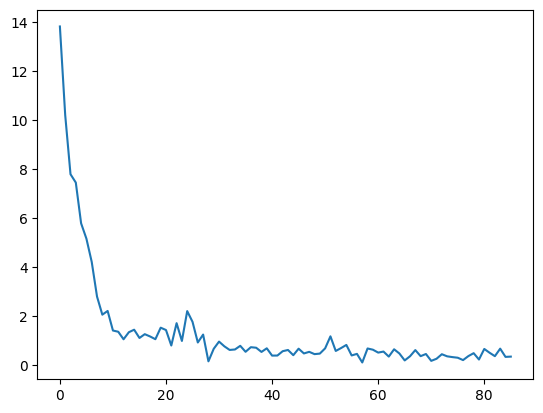

In [76]:
import matplotlib.pyplot as plt

plt.plot(LOSSES_TRAIN[1:])

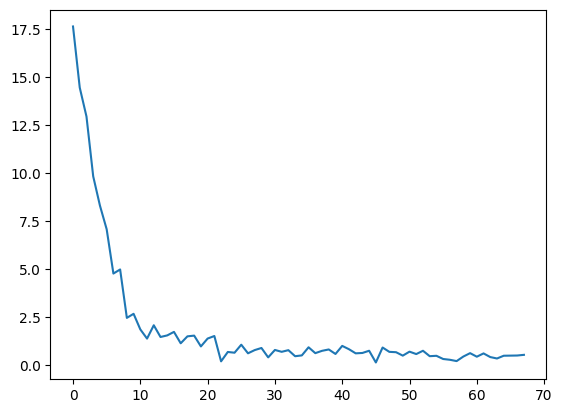

In [90]:
#md2
import matplotlib.pyplot as plt

plt.plot(LOSSES_TRAIN[1:])

In [92]:
np.mean(LOSSES_TRAIN)

1.9625936336545409

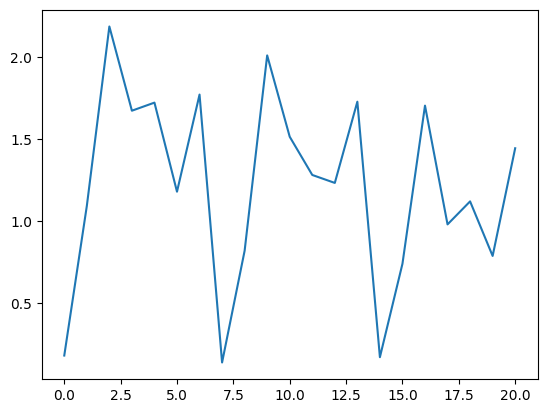

In [93]:
plt.plot(LOSSES_VAL)

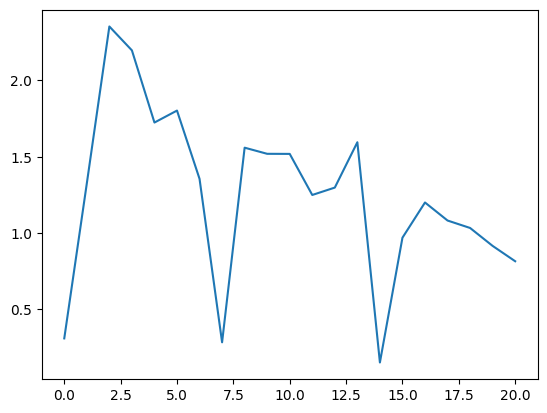

In [41]:
plt.plot(LOSSES_VAL)

In [79]:
torch.save(nn1.state_dict(), 'NN1_RATING_REGR_NOHEADINGS.pth')

In [84]:
np.mean(LOSSES_TRAIN)

1.3618109121747402

MD2

In [85]:
from sklearn.model_selection import train_test_split

X = TRAINTRUE.drop(columns='avg_score')
Y = TRAINTRUE['avg_score']

XTRAIN, XVAL, YTRAIN, YVAL = train_test_split(X, Y, test_size=0.21, stratify=Y, random_state=666, shuffle=True)

In [86]:
TRAINSET = UniversalDataset(XTRAIN['bert_no_q'], XTRAIN['bert_yes_q'], YTRAIN, XTRAIN['relevance'], XTRAIN['review_type'])
VALSET = UniversalDataset(XVAL['bert_no_q'], XVAL['bert_yes_q'], YVAL, XVAL['relevance'], XVAL['review_type'])

In [87]:
len(TRAINSET)

728

In [88]:
BATCH_SIZE = 8

TRAINLOADER = DataLoader(TRAINSET, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
VALLOADER = DataLoader(VALSET, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [89]:
DEVICE = 'cuda'

class SentimentNNRegressor2(nn.Module):
    def __init__(self):
        super(SentimentNNRegressor2, self).__init__()
        self.bert1 = BertModel.from_pretrained('cointegrated/LaBSE-en-ru').to(DEVICE)
        self.bert2 = BertModel.from_pretrained('DeepPavlov/rubert-base-cased').to(DEVICE)
        self.tokenizer1 = AutoTokenizer.from_pretrained('cointegrated/LaBSE-en-ru')
        self.tokenizer2 = AutoTokenizer.from_pretrained('DeepPavlov/rubert-base-cased')
        
        self.fc1 = nn.Sequential(
            nn.Linear(768, 512),
            nn.BatchNorm1d(num_features=512),
            nn.GELU(),
            nn.Dropout(0.1)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(768, 512),
            nn.BatchNorm1d(num_features=512),
            nn.GELU(),
            nn.Dropout(0.1)
        )
        self.head = nn.Linear(1024, 1)
    
    def freeze_berts(self):
        for bert in [self.bert1, self.bert2]:
            for param in bert.parameters():
                param.requires_grad = False
        
    def mean_pooling(self, model_output, attention_mask):
        token_embeddings = model_output[0].to(DEVICE)
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
        sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        return sum_embeddings / sum_mask
    
    def forward(self, bert_no_q):
        x = self.tokenizer1(bert_no_q, padding=True, truncation=True, max_length=512, return_tensors="pt")\
            .to(DEVICE)
        y = self.tokenizer2(bert_no_q, padding=True, truncation=True, max_length=512, return_tensors="pt")\
            .to(DEVICE)
        x_out = self.bert1(**x)
        y_out = self.bert2(**y)
        x_emb = self.mean_pooling(x_out, x["attention_mask"]).to(DEVICE)
        y_emb = self.mean_pooling(y_out, y["attention_mask"]).to(DEVICE)
        
        x_emb = self.fc1(x_emb).to(DEVICE)
        y_emb = self.fc2(y_emb).to(DEVICE)
        xy_emb = torch.cat((x_emb, y_emb), dim=1).to(DEVICE)
        out = self.head(xy_emb).to(DEVICE)
        return out
    
nn2 = SentimentNNRegressor2()
nn2.train()
nn2.freeze_berts()
nn2.to('cuda')
print("done...")

from torch.optim import AdamW
from torch.optim.lr_scheduler import ExponentialLR
from tqdm import tqdm
from transformers import logging
import os
from sklearn.metrics import classification_report, f1_score, roc_auc_score

os.environ["TOKENIZERS_PARALLELISM"] = "false"
logging.set_verbosity_error()

LR = 3e-4
EPOCHS = 3

nn2.train()
nn2.freeze_berts()

# loss_func = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([]))
loss_func = nn.MSELoss()
optimizer = AdamW(lr=LR, params=nn2.parameters())
scheduler = ExponentialLR(gamma=0.8, optimizer=optimizer)
LOSSES_TRAIN, LOSSES_VAL = [], []

for epoch in tqdm(range(EPOCHS)):
    cc_loss = 0
    nn2.train()
    nn2.freeze_berts()
    for step, batch in tqdm(enumerate(TRAINLOADER)):
        inp = batch['bert_yes_q']
        labels = batch['avg_score'].to(DEVICE)
        
        optimizer.zero_grad()
        
        preds = torch.flatten(nn2(inp)).to(DEVICE)
        loss = loss_func(preds, labels)
        
        loss.backward()
        optimizer.step()
        
        cc_loss += loss.item()
        
        if step % 4 == 0:
            LOSSES_TRAIN.append(cc_loss/4)
            print(f"LOSS ON TRAIN STEP {step}: {cc_loss/4.:3f}")
            cc_loss = 0
        
    scheduler.step()
    nn2.eval()
    nn2.freeze_berts()
    cc_loss = 0
    for step, batch in tqdm(enumerate(VALLOADER)):
        inp = batch['bert_yes_q']
        labels = batch['avg_score'].to(DEVICE)

        preds = torch.flatten(nn2(inp)).to(DEVICE)
        loss = loss_func(preds, labels)

        cc_loss += loss.item()

        if step % 4 == 0:
            LOSSES_VAL.append(cc_loss/4)
            print(f"LOSS ON EVAL STEP {step}: {cc_loss/4.:3f}")
            cc_loss = 0

done...


  0%|          | 0/3 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:00,  6.90it/s]
2it [00:00,  7.64it/s]

LOSS ON TRAIN STEP 0: 4.438597



3it [00:00,  6.34it/s]
4it [00:00,  7.31it/s]
5it [00:00,  7.43it/s]
6it [00:00,  7.89it/s]

LOSS ON TRAIN STEP 4: 17.632986



7it [00:00,  7.83it/s]
8it [00:01,  7.78it/s]
9it [00:01,  8.22it/s]
10it [00:01,  7.97it/s]

LOSS ON TRAIN STEP 8: 14.449779



11it [00:01,  7.98it/s]
12it [00:01,  8.25it/s]
13it [00:01,  8.14it/s]
14it [00:01,  7.92it/s]

LOSS ON TRAIN STEP 12: 12.945308



15it [00:01,  7.47it/s]
16it [00:02,  7.55it/s]
17it [00:02,  7.58it/s]
18it [00:02,  7.91it/s]

LOSS ON TRAIN STEP 16: 9.830089



19it [00:02,  8.34it/s]
20it [00:02,  7.96it/s]
21it [00:02,  7.94it/s]
22it [00:02,  7.66it/s]

LOSS ON TRAIN STEP 20: 8.308255



23it [00:02,  7.94it/s]
25it [00:03,  7.99it/s]
26it [00:03,  7.67it/s]

LOSS ON TRAIN STEP 24: 7.076661



27it [00:03,  7.77it/s]
28it [00:03,  7.82it/s]
29it [00:03,  8.07it/s]
30it [00:03,  7.87it/s]

LOSS ON TRAIN STEP 28: 4.769763



31it [00:03,  7.45it/s]
32it [00:04,  7.50it/s]
33it [00:04,  7.83it/s]

LOSS ON TRAIN STEP 32: 4.981675



34it [00:04,  6.55it/s]
35it [00:04,  6.23it/s]
36it [00:04,  6.79it/s]
37it [00:04,  7.31it/s]
38it [00:04,  7.57it/s]

LOSS ON TRAIN STEP 36: 2.461754



39it [00:05,  7.53it/s]
40it [00:05,  6.24it/s]
41it [00:05,  6.94it/s]
42it [00:05,  7.16it/s]

LOSS ON TRAIN STEP 40: 2.673852



43it [00:05,  7.39it/s]
44it [00:05,  7.43it/s]
45it [00:05,  7.68it/s]
46it [00:06,  8.07it/s]

LOSS ON TRAIN STEP 44: 1.862210



47it [00:06,  8.11it/s]
48it [00:06,  8.41it/s]
49it [00:06,  8.02it/s]
50it [00:06,  8.10it/s]

LOSS ON TRAIN STEP 48: 1.382612



51it [00:06,  7.93it/s]
52it [00:06,  7.50it/s]
53it [00:06,  7.56it/s]
54it [00:07,  7.20it/s]

LOSS ON TRAIN STEP 52: 2.077759



55it [00:07,  7.64it/s]
56it [00:07,  7.85it/s]
57it [00:07,  7.85it/s]
58it [00:07,  7.71it/s]

LOSS ON TRAIN STEP 56: 1.466638



59it [00:07,  7.75it/s]
60it [00:07,  7.68it/s]
61it [00:07,  8.04it/s]
62it [00:08,  7.62it/s]

LOSS ON TRAIN STEP 60: 1.549437



63it [00:08,  7.69it/s]
64it [00:08,  7.74it/s]
65it [00:08,  7.87it/s]
66it [00:08,  7.40it/s]

LOSS ON TRAIN STEP 64: 1.732509



67it [00:08,  7.28it/s]
68it [00:08,  7.80it/s]
69it [00:09,  7.89it/s]
70it [00:09,  7.68it/s]

LOSS ON TRAIN STEP 68: 1.138251



71it [00:09,  7.77it/s]
72it [00:09,  8.12it/s]
73it [00:09,  8.55it/s]
74it [00:09,  8.32it/s]

LOSS ON TRAIN STEP 72: 1.500341



75it [00:09,  7.81it/s]
76it [00:09,  7.78it/s]
77it [00:10,  7.75it/s]
78it [00:10,  8.03it/s]

LOSS ON TRAIN STEP 76: 1.537880



79it [00:10,  8.46it/s]
80it [00:10,  8.17it/s]
81it [00:10,  7.64it/s]
82it [00:10,  7.77it/s]

LOSS ON TRAIN STEP 80: 0.976098



83it [00:10,  7.66it/s]
84it [00:10,  7.61it/s]
85it [00:11,  7.57it/s]
86it [00:11,  7.45it/s]

LOSS ON TRAIN STEP 84: 1.385314



87it [00:11,  7.68it/s]
88it [00:11,  7.34it/s]
89it [00:11,  7.70it/s]
90it [00:11,  8.00it/s]

LOSS ON TRAIN STEP 88: 1.517553



91it [00:11,  7.64it/s]

0it [00:00, ?it/s]
1it [00:00,  7.37it/s]
2it [00:00,  7.73it/s]

LOSS ON EVAL STEP 0: 0.180136



3it [00:00,  8.06it/s]
4it [00:00,  8.07it/s]
5it [00:00,  8.43it/s]
6it [00:00,  8.19it/s]

LOSS ON EVAL STEP 4: 1.091435



7it [00:00,  8.15it/s]
8it [00:00,  8.51it/s]
9it [00:01,  6.16it/s]
10it [00:01,  6.77it/s]

LOSS ON EVAL STEP 8: 2.186110



11it [00:01,  6.70it/s]
12it [00:01,  6.93it/s]
13it [00:01,  7.43it/s]
14it [00:01,  7.72it/s]

LOSS ON EVAL STEP 12: 1.672661



15it [00:01,  8.10it/s]
16it [00:02,  8.36it/s]
17it [00:02,  8.45it/s]
19it [00:02,  9.15it/s]

LOSS ON EVAL STEP 16: 1.721934



20it [00:02,  9.21it/s]
21it [00:02,  8.37it/s]
22it [00:02,  8.58it/s]

LOSS ON EVAL STEP 20: 1.178987



23it [00:02,  8.68it/s]
25it [00:03,  8.04it/s]
 33%|███▎      | 1/3 [00:15<00:30, 15.33s/it]

LOSS ON EVAL STEP 24: 1.770932



0it [00:00, ?it/s]
1it [00:00,  6.80it/s]
2it [00:00,  7.77it/s]

LOSS ON TRAIN STEP 0: 0.198480



3it [00:00,  6.46it/s]
4it [00:00,  7.42it/s]
5it [00:00,  7.49it/s]
6it [00:00,  7.93it/s]

LOSS ON TRAIN STEP 4: 0.686699



7it [00:00,  7.88it/s]
8it [00:01,  7.83it/s]
9it [00:01,  8.21it/s]
10it [00:01,  7.93it/s]

LOSS ON TRAIN STEP 8: 0.647857



11it [00:01,  7.91it/s]
12it [00:01,  8.13it/s]
13it [00:01,  8.00it/s]
14it [00:01,  7.79it/s]

LOSS ON TRAIN STEP 12: 1.065352



15it [00:01,  7.35it/s]
16it [00:02,  7.46it/s]
17it [00:02,  7.51it/s]
18it [00:02,  7.87it/s]

LOSS ON TRAIN STEP 16: 0.617155



19it [00:02,  8.32it/s]
20it [00:02,  7.90it/s]
21it [00:02,  7.93it/s]
22it [00:02,  7.69it/s]

LOSS ON TRAIN STEP 20: 0.785340



23it [00:02,  7.97it/s]
24it [00:03,  8.45it/s]
25it [00:03,  7.82it/s]
26it [00:03,  7.52it/s]

LOSS ON TRAIN STEP 24: 0.894382



27it [00:03,  7.65it/s]
28it [00:03,  7.69it/s]
29it [00:03,  7.99it/s]
30it [00:03,  7.85it/s]

LOSS ON TRAIN STEP 28: 0.405065



31it [00:04,  7.42it/s]
32it [00:04,  7.43it/s]
33it [00:04,  7.74it/s]

LOSS ON TRAIN STEP 32: 0.791774



34it [00:04,  6.57it/s]
35it [00:04,  6.21it/s]
36it [00:04,  6.70it/s]
37it [00:04,  7.25it/s]
38it [00:04,  7.67it/s]

LOSS ON TRAIN STEP 36: 0.694942



39it [00:05,  7.61it/s]
40it [00:05,  6.22it/s]
41it [00:05,  6.89it/s]
42it [00:05,  7.23it/s]

LOSS ON TRAIN STEP 40: 0.780850



43it [00:05,  7.42it/s]
44it [00:05,  7.34it/s]
45it [00:05,  7.63it/s]
46it [00:06,  8.19it/s]

LOSS ON TRAIN STEP 44: 0.465709



47it [00:06,  8.21it/s]
48it [00:06,  8.37it/s]
49it [00:06,  7.99it/s]
50it [00:06,  8.21it/s]

LOSS ON TRAIN STEP 48: 0.508383



51it [00:06,  7.99it/s]
52it [00:06,  7.43it/s]
53it [00:06,  7.52it/s]
54it [00:07,  7.26it/s]

LOSS ON TRAIN STEP 52: 0.930506



55it [00:07,  7.67it/s]
56it [00:07,  7.76it/s]
57it [00:07,  7.74it/s]
58it [00:07,  7.66it/s]

LOSS ON TRAIN STEP 56: 0.625499



59it [00:07,  7.79it/s]
60it [00:07,  7.57it/s]
61it [00:08,  7.91it/s]
62it [00:08,  7.55it/s]

LOSS ON TRAIN STEP 60: 0.746062



63it [00:08,  7.72it/s]
64it [00:08,  7.63it/s]
65it [00:08,  7.77it/s]
66it [00:08,  7.34it/s]

LOSS ON TRAIN STEP 64: 0.817895



67it [00:08,  7.29it/s]
68it [00:08,  7.71it/s]
69it [00:09,  7.84it/s]
70it [00:09,  7.80it/s]

LOSS ON TRAIN STEP 68: 0.583096



71it [00:09,  7.94it/s]
72it [00:09,  8.11it/s]
73it [00:09,  8.53it/s]
74it [00:09,  8.49it/s]

LOSS ON TRAIN STEP 72: 1.003077



75it [00:09,  7.93it/s]
76it [00:09,  7.74it/s]
77it [00:10,  7.74it/s]
78it [00:10,  8.15it/s]

LOSS ON TRAIN STEP 76: 0.830317



79it [00:10,  8.58it/s]
80it [00:10,  8.12it/s]
81it [00:10,  7.62it/s]
82it [00:10,  7.84it/s]

LOSS ON TRAIN STEP 80: 0.615671



83it [00:10,  7.72it/s]
84it [00:10,  7.57it/s]
85it [00:11,  7.56it/s]
86it [00:11,  7.59it/s]

LOSS ON TRAIN STEP 84: 0.634885



87it [00:11,  7.79it/s]
88it [00:11,  7.32it/s]
89it [00:11,  7.71it/s]
90it [00:11,  8.08it/s]

LOSS ON TRAIN STEP 88: 0.750808



91it [00:11,  7.64it/s]

0it [00:00, ?it/s]
1it [00:00,  7.32it/s]
2it [00:00,  7.53it/s]

LOSS ON EVAL STEP 0: 0.137863



3it [00:00,  7.90it/s]
4it [00:00,  7.90it/s]
5it [00:00,  8.31it/s]
6it [00:00,  8.12it/s]

LOSS ON EVAL STEP 4: 0.819074



7it [00:00,  8.09it/s]
8it [00:00,  8.38it/s]
9it [00:01,  6.13it/s]
10it [00:01,  6.75it/s]

LOSS ON EVAL STEP 8: 2.009819



11it [00:01,  6.73it/s]
12it [00:01,  7.01it/s]
13it [00:01,  7.40it/s]
14it [00:01,  7.61it/s]

LOSS ON EVAL STEP 12: 1.513858



15it [00:01,  8.00it/s]
16it [00:02,  8.35it/s]
17it [00:02,  8.41it/s]


LOSS ON EVAL STEP 16: 1.280980


19it [00:02,  9.07it/s]
20it [00:02,  9.13it/s]
21it [00:02,  8.32it/s]
22it [00:02,  8.53it/s]

LOSS ON EVAL STEP 20: 1.232445



23it [00:02,  8.63it/s]
25it [00:03,  7.99it/s]
 67%|██████▋   | 2/3 [00:30<00:15, 15.34s/it]

LOSS ON EVAL STEP 24: 1.727622



0it [00:00, ?it/s]
1it [00:00,  7.07it/s]
2it [00:00,  7.97it/s]

LOSS ON TRAIN STEP 0: 0.139812



3it [00:00,  6.53it/s]
4it [00:00,  7.48it/s]
5it [00:00,  7.52it/s]
6it [00:00,  7.97it/s]

LOSS ON TRAIN STEP 4: 0.918764



7it [00:00,  7.93it/s]
8it [00:01,  7.87it/s]
9it [00:01,  8.24it/s]
10it [00:01,  7.96it/s]

LOSS ON TRAIN STEP 8: 0.693221



11it [00:01,  7.92it/s]
12it [00:01,  8.16it/s]
13it [00:01,  8.06it/s]
14it [00:01,  7.85it/s]

LOSS ON TRAIN STEP 12: 0.674494



15it [00:01,  7.41it/s]
16it [00:02,  7.48it/s]
17it [00:02,  7.50it/s]
18it [00:02,  7.85it/s]

LOSS ON TRAIN STEP 16: 0.496175



19it [00:02,  8.16it/s]
20it [00:02,  7.88it/s]
21it [00:02,  7.91it/s]
22it [00:02,  7.68it/s]

LOSS ON TRAIN STEP 20: 0.703246



23it [00:02,  7.93it/s]
25it [00:03,  8.01it/s]
26it [00:03,  7.70it/s]

LOSS ON TRAIN STEP 24: 0.577649



27it [00:03,  7.77it/s]
28it [00:03,  7.80it/s]
29it [00:03,  8.07it/s]
30it [00:03,  7.94it/s]

LOSS ON TRAIN STEP 28: 0.749529



31it [00:03,  7.47it/s]
32it [00:04,  7.49it/s]
33it [00:04,  7.79it/s]

LOSS ON TRAIN STEP 32: 0.467801



34it [00:04,  6.59it/s]
35it [00:04,  6.23it/s]
36it [00:04,  6.79it/s]
37it [00:04,  7.31it/s]
38it [00:04,  7.68it/s]

LOSS ON TRAIN STEP 36: 0.487453



39it [00:05,  7.58it/s]
40it [00:05,  6.26it/s]
41it [00:05,  6.91it/s]
42it [00:05,  7.21it/s]

LOSS ON TRAIN STEP 40: 0.320901



43it [00:05,  7.38it/s]
44it [00:05,  7.40it/s]
45it [00:05,  7.56it/s]
46it [00:06,  8.14it/s]

LOSS ON TRAIN STEP 44: 0.280400



47it [00:06,  8.15it/s]
48it [00:06,  8.46it/s]
49it [00:06,  8.01it/s]
50it [00:06,  8.25it/s]

LOSS ON TRAIN STEP 48: 0.211881



51it [00:06,  7.97it/s]
52it [00:06,  7.52it/s]
53it [00:06,  7.55it/s]
54it [00:07,  7.24it/s]

LOSS ON TRAIN STEP 52: 0.449093



55it [00:07,  7.63it/s]
56it [00:07,  7.80it/s]
57it [00:07,  7.76it/s]
58it [00:07,  7.66it/s]

LOSS ON TRAIN STEP 56: 0.625066



59it [00:07,  7.77it/s]
60it [00:07,  7.68it/s]
61it [00:07,  8.01it/s]
62it [00:08,  7.62it/s]

LOSS ON TRAIN STEP 60: 0.440885



63it [00:08,  7.77it/s]
64it [00:08,  7.77it/s]
65it [00:08,  7.80it/s]
66it [00:08,  7.24it/s]

LOSS ON TRAIN STEP 64: 0.611523



67it [00:08,  7.19it/s]
68it [00:08,  7.71it/s]
69it [00:09,  7.81it/s]
70it [00:09,  7.57it/s]

LOSS ON TRAIN STEP 68: 0.421461



71it [00:09,  7.78it/s]
72it [00:09,  8.11it/s]
73it [00:09,  8.52it/s]
74it [00:09,  8.45it/s]

LOSS ON TRAIN STEP 72: 0.347421



75it [00:09,  7.87it/s]
76it [00:09,  7.81it/s]
77it [00:10,  7.76it/s]
78it [00:10,  8.12it/s]

LOSS ON TRAIN STEP 76: 0.490994



79it [00:10,  8.53it/s]
80it [00:10,  8.20it/s]
81it [00:10,  7.61it/s]
82it [00:10,  7.73it/s]

LOSS ON TRAIN STEP 80: 0.496481



83it [00:10,  7.66it/s]
84it [00:10,  7.63it/s]
85it [00:11,  7.60it/s]
86it [00:11,  7.50it/s]

LOSS ON TRAIN STEP 84: 0.502457



87it [00:11,  7.74it/s]
88it [00:11,  7.39it/s]
89it [00:11,  7.68it/s]
90it [00:11,  7.85it/s]

LOSS ON TRAIN STEP 88: 0.537125



91it [00:11,  7.62it/s]

0it [00:00, ?it/s]
1it [00:00,  7.24it/s]
2it [00:00,  7.44it/s]

LOSS ON EVAL STEP 0: 0.170231



3it [00:00,  7.87it/s]
4it [00:00,  7.88it/s]
5it [00:00,  8.31it/s]
6it [00:00,  8.11it/s]

LOSS ON EVAL STEP 4: 0.739515



7it [00:00,  8.10it/s]
8it [00:00,  8.42it/s]
9it [00:01,  6.15it/s]
10it [00:01,  6.79it/s]

LOSS ON EVAL STEP 8: 1.703510



11it [00:01,  6.76it/s]
12it [00:01,  7.04it/s]
13it [00:01,  7.51it/s]
14it [00:01,  7.74it/s]

LOSS ON EVAL STEP 12: 0.979661



15it [00:01,  8.12it/s]
16it [00:02,  8.49it/s]
17it [00:02,  8.52it/s]
18it [00:02,  8.89it/s]

LOSS ON EVAL STEP 16: 1.119879



19it [00:02,  9.05it/s]
20it [00:02,  9.16it/s]
21it [00:02,  8.21it/s]
22it [00:02,  8.46it/s]

LOSS ON EVAL STEP 20: 0.787340



23it [00:02,  8.61it/s]
25it [00:03,  8.01it/s]
100%|██████████| 3/3 [00:46<00:00, 15.36s/it]

LOSS ON EVAL STEP 24: 1.443809
